In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import ssl

import nltk
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

In [2]:
df = pd.read_csv("archive/IMDb movies.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85855 entries, 0 to 85854
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_title_id          85855 non-null  object 
 1   title                  85855 non-null  object 
 2   original_title         85855 non-null  object 
 3   year                   85855 non-null  object 
 4   date_published         85855 non-null  object 
 5   genre                  85855 non-null  object 
 6   duration               85855 non-null  int64  
 7   country                85791 non-null  object 
 8   language               85022 non-null  object 
 9   director               85768 non-null  object 
 10  writer                 84283 non-null  object 
 11  production_company     81400 non-null  object 
 12  actors                 85786 non-null  object 
 13  description            83740 non-null  object 
 14  avg_vote               85855 non-null  float64
 15  vo

/Users/arinjay/Desktop/CS 5100/Project/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df['genre'] = df['genre'].replace('unknown', np.nan)
df = df.dropna(axis=0, subset=['genre'])
print(df.tail())

      imdb_title_id                           title  \
85850     tt9908390                         Le lion   
85851     tt9911196  De Beentjes van Sint-Hildegard   
85852     tt9911774       Padmavyuhathile Abhimanyu   
85853     tt9914286               Sokagin Çocuklari   
85854     tt9914942      La vida sense la Sara Amat   

                       original_title  year date_published          genre  \
85850                         Le lion  2020     2020-01-29         Comedy   
85851  De Beentjes van Sint-Hildegard  2020     2020-02-13  Comedy, Drama   
85852       Padmavyuhathile Abhimanyu  2019     2019-03-08          Drama   
85853               Sokagin Çocuklari  2019     2019-03-15  Drama, Family   
85854      La vida sense la Sara Amat  2019     2020-02-05          Drama   

       duration          country       language                director  ...  \
85850        95  France, Belgium         French  Ludovic Colbeau-Justin  ...   
85851       103      Netherlands  German, Dutc

In [4]:
print(len(df))
print(df.shape)
a = df['genre'].value_counts()[:20]
b = a.keys().tolist()
print(b)
df = df[df.genre.isin(b)]
df = df.reset_index(drop=True)

85855
(85855, 22)
['Drama', 'Comedy', 'Comedy, Drama', 'Drama, Romance', 'Comedy, Romance', 'Comedy, Drama, Romance', 'Horror', 'Drama, Thriller', 'Crime, Drama', 'Action, Crime, Drama', 'Thriller', 'Horror, Thriller', 'Crime, Drama, Thriller', 'Action, Drama', 'Drama, War', 'Action', 'Crime, Drama, Mystery', 'Action, Adventure, Drama', 'Action, Adventure, Comedy', 'Comedy, Crime']


<AxesSubplot:xlabel='Count', ylabel='genre'>

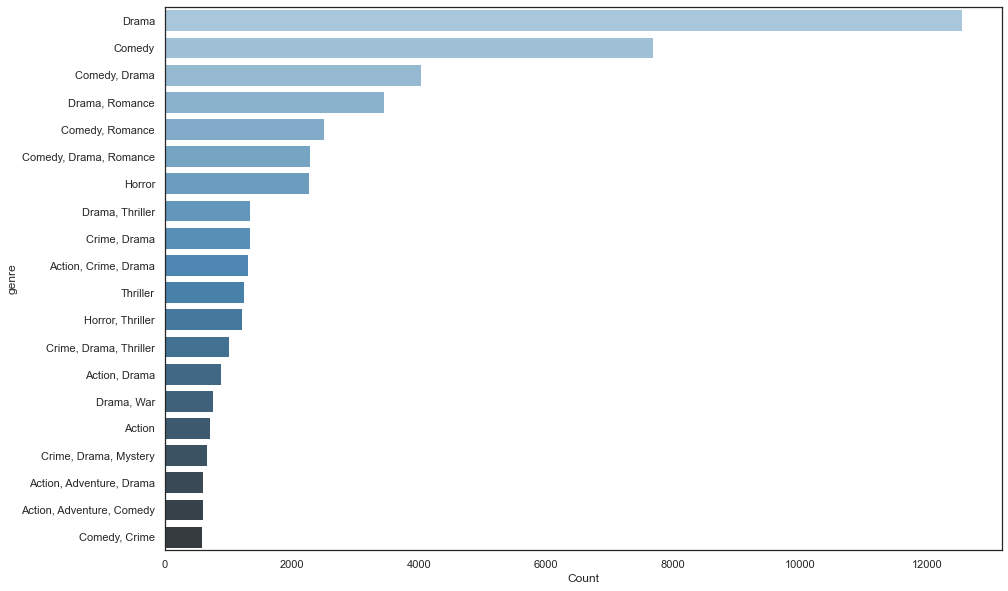

In [5]:
sns.set(style="white")
genre_to_count=pd.DataFrame({'genre':a.index, 'Count':a.values})
plt.figure(figsize=(15,10))
sns.barplot(y="genre", x="Count", data=genre_to_count,palette="Blues_d")

In [6]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arinjay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
def plotToWords(raw_plot):
    letters_only = re.sub("[^a-zA-Z]", " ", str(raw_plot))
    lower_case = letters_only.lower()
    words = lower_case.split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return (" ".join(meaningful_words))

In [8]:
def preprocess(dataframe):
    cleaned_description = []
    for i in range(0,len(dataframe)):
        cleaned_description.append(plotToWords(dataframe.iloc[i]['description']))
    dataframe['description']=cleaned_description
    return dataframe

In [9]:
df=preprocess(df)
print(df["description"][:10])

0    two men high rank wooing beautiful famous eque...
1    richard gloucester uses manipulation murder ga...
2    dr friedrich wife becomes mentally unstable re...
3    inspector juve tasked investigate capture infa...
4    single mother separated children due financial...
5    part two louis feuillade hour epic follows fan...
6    leslie swayne adventurer order obtain enough m...
7    army pilot visit home another army pilot neigh...
8    body disappears inside prison series crimes ta...
9    john howard payne miserable point life writes ...
Name: description, dtype: object


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), max_features=4000)
features = tfidf.fit_transform(df.description).toarray()
labels = df.genre
features.shape
print(features)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['description'], df['genre'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [12]:
print(clf.predict(count_vect.transform(["In an interview with CBC Radio, UniversitÃ© de MontrÃ©al History Professor Dominique St. Arnaud tells Diane about her new book, Variations on the Idea of Happiness, which discusses her thesis that modern society's fixation on self-indulgence is indicative of its decline, predicting a collapse in the ""American Empire,"" of which Quebec is on the periphery. Several of Dominique and Diane's friends, mostly intellectual history professors at the university, prepare for a dinner later in the day, with the men at work in the kitchen while the women work out at the gym. As the dinner draws nearer, the men and women mainly talk about their sex lives, with the men being open about their adulteries, including RÃ©my, who is married to Louise. Most of the women in the circle of friends have had sex with RÃ©my, though he is not attractive, but they conceal this from Louise to spare her feelings. Louise has been to an orgy with RÃ©my, but believes he is generally faithful to her in Montreal. The friends are also accepting of their homosexual friend Claude, who speaks about pursuing men reckless of fear of STDs, while secretly being fearful of having one. During the dinner party, the friends listen to Dominique's theories about the decline of society, with Louise expressing skepticism. To retaliate against Louise, Dominique reveals she has had sex with RÃ©my and their friend Pierre, causing her to have an emotional meltdown. By morning, relationships have gone back to normal."])))

['Drama']


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter = 1000),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df_accuracy = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [19]:
cv_df_accuracy.groupby('model_name').accuracy.mean()

model_name
LinearSVC             0.334451
LogisticRegression    0.360900
MultinomialNB         0.344895
Name: accuracy, dtype: float64

In [20]:
cv_df_accuracy.groupby('model_name').accuracy.std()

model_name
LinearSVC             0.014253
LogisticRegression    0.009441
MultinomialNB         0.004571
Name: accuracy, dtype: float64

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter = 1000),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    f1_micros = cross_val_score(model, features, labels, scoring='f1_micro', cv=CV)
    for fold_idx, f1_micro in enumerate(f1_micros):
        entries.append((model_name, fold_idx, f1_micro))
cv_df_f2 = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1_micro'])

In [24]:
cv_df_f2.groupby('model_name').f1_micro.mean()

model_name
LinearSVC             0.334430
LogisticRegression    0.360900
MultinomialNB         0.344895
Name: f1_micro, dtype: float64

In [25]:
cv_df_f2.groupby('model_name').f1_micro.std()

model_name
LinearSVC             0.014235
LogisticRegression    0.009441
MultinomialNB         0.004571
Name: f1_micro, dtype: float64

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter = 1000),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    recall_micros = cross_val_score(model, features, labels, scoring='recall_micro', cv=CV)
    for fold_idx, recall_micro in enumerate(recall_micros):
        entries.append((model_name, fold_idx, recall_micro))
cv_df_recall = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'recall_micro'])

In [26]:
cv_df_recall.groupby('model_name').recall_micro.mean()

model_name
LinearSVC             0.334451
LogisticRegression    0.360900
MultinomialNB         0.344895
Name: recall_micro, dtype: float64

In [30]:
cv_df_recall.groupby('model_name').recall_micro.std()

model_name
LinearSVC             0.014253
LogisticRegression    0.009441
MultinomialNB         0.004571
Name: recall_micro, dtype: float64

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter = 1000),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    precision = cross_val_score(model, features, labels, scoring='precision_micro', cv=CV)
    for fold_idx, recall_micro in enumerate(precision):
        entries.append((model_name, fold_idx, precision))
cv_df_precision = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'precision'])

In [28]:
print(cv_df_precision.precision.mean())
print(cv_df_precision.precision)
print(cv_df_precision.groupby('model_name'))

[0.3315998  0.34801528 0.35211915 0.35049176 0.35148235]
0     [0.31108045001061346, 0.3305030779027807, 0.34...
1     [0.31108045001061346, 0.3305030779027807, 0.34...
2     [0.31108045001061346, 0.3305030779027807, 0.34...
3     [0.31108045001061346, 0.3305030779027807, 0.34...
4     [0.31108045001061346, 0.3305030779027807, 0.34...
5     [0.33899384419443856, 0.3515177244746338, 0.34...
6     [0.33899384419443856, 0.3515177244746338, 0.34...
7     [0.33899384419443856, 0.3515177244746338, 0.34...
8     [0.33899384419443856, 0.3515177244746338, 0.34...
9     [0.33899384419443856, 0.3515177244746338, 0.34...
10    [0.3447251114413076, 0.3620250477605604, 0.368...
11    [0.3447251114413076, 0.3620250477605604, 0.368...
12    [0.3447251114413076, 0.3620250477605604, 0.368...
13    [0.3447251114413076, 0.3620250477605604, 0.368...
14    [0.3447251114413076, 0.3620250477605604, 0.368...
Name: precision, dtype: object
